# Ponchon Savarit Diagram Code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from scipy.optimize import root

class PonchonSavarit:
    def __init__(self,y_func, HV_func, HL_func):
        '''
        y_func : function which maps x to y 
                must: y_func(1) = 1 , y_func(0) = 0
        
        HV_func : Vapor Enthalpy function, HV = HV_func(x)
        HL_func : Liquid Enthalpy function, HL = HL_func(x)
        '''
        self.y_func = y_func
        self.HV_func = HV_func
        self.HL_func = HL_func

        self.AdjustAx1 = True      #if true will adjust ax1 y_lim
        self.record_data = True    #if true adds the x,nx,y,L,G to recording lists

        self.ax1yMax = None
        self.ax1yMin = None

        #Computing main curvers fo Y, X; HL, HV
        self.Npoints = np.linspace(0.0, 1.0, num=200)
        self.Ys = self.y_func(self.Npoints)
        self.HVs = self.HV_func(self.Npoints)
        self.HLs = self.HL_func(self.Npoints)


        self.HasOpenSteam = False
        self.isMultipleFeed = False

        self.plotConfig()    #setting displaying cofigiuration

################################################################################
 
    def plotConfig(self,  figsize = (10,10),
                            HVcolor ='b', HLcolor = 'y',
                            yxcolor = 'k', xxcolor = 'k',
                            StageC = 'r',
                            GPointC = 'g', LPointC = 'y',
                            XXPointC = 'b', YXPointC ='y',
                            feedC = 'b', initPC = 'r', oplC = 'r',
                            linewidth = 2, StageLinewidth = 3):
        '''
            This function is used to costumize the coloring and line widths of 
            the plots
        '''
        self.figsize = figsize      # matplotlib figure figsize
        
        self.HVcolor = HVcolor      # Vapor Enthalpy curve color
        self.HLcolor = HLcolor      # Liquid Enthalpy curve color
        self.yxcolor = yxcolor      # YX equilibrium curve color
        self.xxcolor = xxcolor      # XX equilibrium curve color

        self.GPointC = GPointC      # G Point color
        self.LPointC = LPointC      # L Point color
        self.XXPointC = XXPointC    # XX Point color
        self.YXPointC = YXPointC    # YX Point color

        self.feedC = feedC    # vertical and horizantal line of feed Point Color
        self.initPC = initPC  # color of (xW, xD,zF) Point Color

        self.oplC = oplC      # Operating line Color

        self.linewidth = linewidth              # HL,HV, XX, YX line width
        self.StageLinewidth = StageLinewidth    # Stage Line width
        self.StageC = StageC

################################################################################
 
    def _plotInit(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(nrows = 2,
                                                      ncols = 1,
                                                      sharex = True,
                                                      figsize = self.figsize
                                                      )
        '''
        Helper function for initialing matplotlib figure
        '''
        self.ax1.set_xlim(0.0, 1.0)
        self.ax2.set_xlim(0.0, 1.0)

        self.ax2.set_ylim(0.0, 1.0)

        if self.ax1yMax != None:
            self.ax1.set_ylim(self.ax1yMin, self.ax1yMax)

################################################################################
 
    def _SubplotConnect(self, xyA, xyB):
        '''
        Helper Function for ploting a line between two subplots
        Draws a line from xyA(x1,y1) in ax1 to xyB(x2,y2) in ax2
        xyA : Point (x1[float], y1[float])
        xyB : Point (x2[float], y2[float])
        '''
        con = ConnectionPatch(xyA = xyA,
                              xyB = xyB,
                              axesA=self.ax1, axesB=self.ax2,
                              coordsA='data',coordsB='data')
        
        con.set_linestyle(':')      #seting "..." style to line
        self.ax2.add_artist(con)

################################################################################
 
    def raw_plot(self):
        '''
        plots just the main curves(XX, YX, HL, HV)
        '''
        
        self._plotInit()     #initialing the figure

        #ploting X_HV
        self.ax1.plot(self.Npoints, self.HVs,
                      color = self.HVcolor, linewidth = self.linewidth)
        
        #ploting X_HL
        self.ax1.plot(self.Npoints, self.HLs,
                      color = self.HLcolor, linewidth = self.linewidth)

        #ploting X_X
        self.ax2.plot(self.Npoints, self.Npoints,
                      color = self.xxcolor, linewidth = self.linewidth)
        
        #ploting Y_X
        self.ax2.plot(self.Npoints, self.Ys,
                      color = self.yxcolor, linewidth = self.linewidth)

        self.ax1.set_ylabel("Enthalpy, H")
        self.ax2.set_ylabel("Y")
        self.ax2.set_xlabel("X")

        print(self.HVcolor)

################################################################################
   
    def _liner(slef,A,B):
        '''
        A helper function which creates a line function ax + b from 2 given points
        A: (xA[float], yA[float])
        B: (xB[float], yB[float])
        '''
        xA, yA = A
        xB, yB = B

        #sloope of the line
        a = (yB - yA)/(xB - xA)

        #creating line function
        def func(x):
            return a*(x - xA) + yA

        return func

################################################################################

    def DistillationFrac(self, F, zF, xD, xW):
        '''
        F = D + W
        F.zF = D.xD + W.xW
        given: F, zF, xD, xW
        returns D,W
        '''

        a = np.array([[1.0, 1.0], [xD, xW]])
        b = np.array([F, F*zF])

        result = np.linalg.solve(a, b)

        D = result[0]
        W = result[1]

        return (D,W)

################################################################################
 
    def addData(self, xD, xW, zF, F, dHD=None, dHW=None, HF=None, OS=None, 
                HOS=None,zF2=None,F2=None,  HF2=None):
        '''
        adds data for future computations
        
        xD: molar fraction of target distilation
        xW: molar fraction of distillation waste
        zF: molar fraction of feed
        dHD: delta D
        dHW: delta W
        HF: feed Enthalpy
        * just two of [dHW, dHD, HF] must be filled and the third value will 
        be computed automaticaly
        * Must: 0 < xD, xW, zF <1 
        * Must: xD + xW = 1.0
        '''
        #Computing F,W,D
        if F2 == None:
            self.F = F
            self.D, self.W = self.DistillationFrac(F, zF, xD, xW)
        else:
            nF = F + F2
            nzF = (F*zF + F2*zF2)/(nF)
            self.D, self.W = self.DistillationFrac(nF, nzF, xD, xW)

        if zF2 != None:
            self.isMultipleFeed = True
            self.feeds = [(zF,F,HF),(zF2, F2,HF2)]
            self.feeds.sort(reverse=True)

            self.dxM = xD + (self.feeds[0][1]/(self.D - self.feeds[0][1]))*(xD - self.feeds[0][0])
            self.dHM = (self.D*dHD - self.feeds[0][0]*self.feeds[0][2])/(self.D - self.feeds[0][1])

            dHW = self._liner((self.dxM,self.dHM),(self.feeds[1][0],self.feeds[1][2]))(xW)
        else:
            #booleans
            DisN = (dHD == None)
            WisN = (dHW == None)
            HFisN = (HF == None)
            
            if  DisN == True and WisN == False and HFisN == False:
                dHD = self._liner((xW,dHW),(zf,HF))(xD)           #compting dHD

            elif  DisN == False and WisN == True and HFisN == False:
                dHW = self._liner((xD,dHD),(zf,HF))(xW)           #compting dHW

            elif  DisN == False and WisN == False and HFisN == True:
                HF = self._liner((xW,dHW),(xD,dHD))(zF)           #compting HF

            else:
                raise Exception("just two of dHD, dHW and HF must be filled")

        self.G0 = self.HV_func(xD)  #Computing G0

        self.xD = xD
        self.xW = xW
        self.zF = zF
        self.F = F
        self.dHD = dHD
        self.dHW = dHW
        self.dxW = self.xW
        self.HF = HF

        self._OplineHL()  #the point Operating line hits the Liquid Enthalpy line


        #Initialing data recorders
        self.Gs = [self.HV_func(self.xD)]
        self.xs = [self.xD]
        self.Ls = []
        self.ys = []
        self.lxs = []



        if OS != None:
            self.HasOpenSteam = True
            if HOS == None:
                HOS = self.HV_func(0.0)
                

            self.HOS = HOS
            self.OS = OS

            #modifing delta W Point

            self.dHW = ((self.W * self.HL_func(self.xW)) - (self.OS* self.HOS))/(self.W - self.OS)
            self.dxW = (self.W * self.xW)/(self.W - self.OS)
            self.dHD = self._liner((self.dxW,self.dHW),(self.zF,self.HF))(xD) 

################################################################################

    def Condencor(self, zF, xW, xD, F, R, Complete=False):

        (D,W) = self.DistillationFrac(F, zF, xD, xW)

        HG1 = self.HV_func(xD)
        HL0 = self.HL_func(xD)

        if Complete == True:
            Qc = (R + 1)* D *(HG1 - HL0)
        
        elif Complete == False:
            Qc = R * D * (HG1 - HL0)

        dHD = self.HL_func(xD)+ Qc/D
        return (Qc,dHD)

################################################################################
         
    def _drawLine(self, P1, P2, style, ax = 1, linewidth = 1):
        '''
        A helper function which draw a line form P1 to P2
        
        P1: Point 1 (x[float], y[float])
        P2: Point 2 (x[float], y[float])
        '''
        if ax == 1:
            self.ax1.plot([P1[0], P2[0]], [P1[1], P2[1]],
                                         style,linewidth= linewidth)
        elif ax == 2:
            self.ax2.plot([P1[0], P2[0]], [P1[1], P2[1]],
                                         style,linewidth = linewidth)

################################################################################
 
    def _drawPoint(self, x, y, ax=1,color='r'):
        '''
        helper function draws Point(x,y) in the given `ax`
        '''
        if ax == 1:
            self.ax1.plot([x],[y],color + 'o')
        elif ax == 2:
            self.ax2.plot([x],[y],color + 'o')
  
################################################################################
 
    def plot_data(self):
        '''
        this function displays initial condition of Ponchon-Saverit method
        '''
        maxHV = np.max(self.HVs)
        minHL = np.min(self.HLs)

        #Adjusting the ax1 y_lim (False is used for findNmin() )
        if self.AdjustAx1 == True:
            self.ax1yMax = maxHV*0.5 + self.dHD
            self.ax1yMin = self.dHW - maxHV*0.5

        else:
            self.ax1yMax = maxHV * 1.5
            self.ax1yMin = minHL - maxHV*0.5

        self.raw_plot()     #displying main curves

        self.y1min, self.y1max = self.ax1.get_ylim()  
        self.y2min, self.y2max = self.ax2.get_ylim()

        #drawing xD and xW vertical lines
        self._SubplotConnect((self.xD,self.y1max),(self.xD, self.y2min))
        self._SubplotConnect((self.xW,self.y1max),(self.xW, self.y2min))
        
        self._drawPoint(self.zF, self.HF,color = self.initPC)       # Feed Point
        self._drawPoint(self.xD, self.dHD,color = self.initPC)      # delta D Point
        self._drawPoint(self.dxW, self.dHW,color = self.initPC)      # delta W Point

        # drawing Feed Vertical and Horizantal Line
        self._drawLine((self.zF, self.y1min),(self.zF, self.HF),self.feedC+':')
        self._drawLine((self.zF, self.HF),(0, self.HF), self.feedC+':')
        
        # drawing Operating Line
        if self.isMultipleFeed == False:
            self._drawLine((self.dxW,self.dHW), (self.xD, self.dHD), self.oplC+':')

       # if self.HasOpenSteam == True:
       #     self._drawLine((self.dxW,self.dHW),(0.0, self.HOS),"k:")
       #     self._drawPoint(0.0, self.HOS, color = self.initPC   )
        if self.isMultipleFeed == True:
            self._drawPoint(self.feeds[1][0],self.feeds[1][2],color = self.initPC)
            self._drawLine((self.feeds[1][0], self.y1min),(self.zF, self.feeds[1][2]),self.feedC+':')
            self._drawLine((self.feeds[1][0], self.feeds[1][2]),(0, self.feeds[1][2]), self.feedC+':')

            self._drawPoint(self.dxM, self.dHM, color = self.initPC)

            self._drawLine((self.dxM,self.dHM),(self.dxW,self.dHW), self.oplC+":")
            self._drawLine((self.xD,self.dHD),(self.OP,self.HL_func(self.OP)), self.oplC+":")

################################################################################
 
    def _YXsolver(self,X):
        '''
        Helper function for finding the x of y equal to given X
        Simlarly to drawing a horizantal line from (X,X) and finding 
        the intersection point with (Y,nX)
        '''
        Y = X
        def func(x):
            return self.y_func(x) - Y
        
        nX = root(func, 0.01)['x'][0]
        return nX

################################################################################
 
    def _nGsolver(self, LP, refP):
        '''
        a helper function for finidng the new G point from L Point and 
        refrence point
        
        refrence point can be `delta D` or `delta W`
        LP: Point(x[float], y[float])
        refP : Point(x[float],y[float])
        '''
        line = self._liner(LP, refP)

        def func(X):
            return self.HV_func(X) - line(X)

        init_x = (LP[0] + refP[0])/2
        return root(func,init_x)['x'][0]

################################################################################
 
    def _OplineHL(self):
        '''
        this helper function is used for finidng Operating line and Liquid Enthalpy intersection
        '''
        if self.isMultipleFeed == False:
            line = self._liner((self.zF,self.HF), (self.xD, self.dHD))

            def func(x):
                return line(x) - self.HL_func(x)

            self.OP = root(func, self.zF)['x'][0]
        elif self.isMultipleFeed == True:
            line = self._liner((self.feeds[0][0],self.feeds[0][2]), (self.xD, self.dHD))

            def func(x):
                return line(x) - self.HL_func(x)

            self.OP = root(func, self.zF)['x'][0]

            line = self._liner((self.feeds[1][0],self.feeds[1][2]), (self.dxM, self.dHM))

            def func(x):
                return line(x) - self.HL_func(x)

            self.OP2 = root(func, self.zF)['x'][0]   

################################################################################
 
    def step(self,x):
        '''
        runs every step of ponchon savarit Calculation
        
        x is the intial fraction of the Ponchon savarit method
        
        must : 0 < x < 1
        '''
        
        G = self.HV_func(x)                           #Computes GH
        
        self._drawPoint(x,G,ax=1,color=self.GPointC)  #draws G Point
        self._SubplotConnect((x,G),(x,x))             #draws vertical line G -> XX
        self._drawPoint(x,x,ax=2,color=self.XXPointC) #draws  XX Point
        
        nx = self._YXsolver(x)                        #finding YXs x
        
        y = self.y_func(nx)                           #Computes Y of the new x

        self._drawPoint(nx,y,ax=2,color=self.YXPointC)#draws YX Point
        self._drawLine((x,x),(nx,y),ax=2,style='k:')  #draws horizantal line XX -> YX

        L = self.HL_func(nx)                          #Computes new L Point
        self._drawPoint(nx,L,ax=1,color=self.LPointC) #draws L Point
        self._SubplotConnect((nx,L),(nx,y))           #draws vertical line YX -> L

        '''
        check if L_Operation line intersection is passed or not, 
        if yes changes the refrence Point to `delta W`
        '''
        if self.isMultipleFeed == False:
            if self.OP < nx:
                refPoint = (self.xD, self.dHD)
            elif self.OP > nx:
                refPoint = (self.dxW, self.dHW)

        else:
            if self.OP < nx:
                refPoint = (self.xD, self.dHD)
            elif self.OP > nx and nx > self.OP2:
                refPoint = (self.dxM, self.dHM)
            elif self.OP > nx:
                refPoint = (self.dxW, self.dHW)


        nGx = self._nGsolver((nx,L),refPoint)  #finding the new G Point
        nG = self.HV_func(nGx)                 #Computes new G point Enthalpy
        
        self._drawPoint(nGx, nG,ax=1,color=self.GPointC) #draws new G Point
        
        '''
        if Operation line HL intersection passed changes 
        line drawing line refrence
        '''
        
        if refPoint[1]> self.HF:
            self._drawLine((nx,L), refPoint, ax=1, style='k:')
        elif refPoint[1] < self.HF:
            self._drawLine((nGx,G), refPoint, ax=1, style='k:')

        #draws the stage line
        self._drawLine((nx,L),(x,G),ax=1, style = self.StageC,linewidth = self.StageLinewidth)

        #record computed data if True
        if self.record_data == True:
            self.Gs.append(nG)
            self.Ls.append(L)
            self.lxs.append(nx)
            self.ys.append(y)
            self.xs.append(nGx)

        return nGx

################################################################################
 
    def _endCon(self) -> bool:
        '''
        checks if the end condition is satisfied or not
        '''
        if self.lxs[-1] < self.xW:
            return True
        else:
            return False

################################################################################
 
    def _lastStage(self):
        '''
        helper function for computing last stange 
        '''
        xL = self.lxs[-1]       #retriving last x of L Point
        HL = self.Ls[-1]        #retriving last H of L Point

        xG = self.xs[-1]        #retriving last x of G Point
        HG = self.Gs[-1]        #retriving last H of G Point
        
        line = self._liner((xL,HL),(xG,HG))
        endH = line(self.xW)    #intersection of line with xW vertical line


        fullLine = np.sqrt(np.power((xL-xG),2) + np.power((HL -HG),2))              #complete stage line length
        smallLine = np.sqrt(np.power((xG - self.xW),2) + np.power((HG - endH),2))   #real stage line length

        return smallLine/fullLine

################################################################################
 
    def ComputeN(self, returnListData=False, maxIter = 20):
        '''
        Computes number of stages needed for distillation
        if returnListData == True: it will return (data, listdata)
        list data list of Xs,Gs,Ls,Ys Points
        '''
        self.record_data = True
        #Initializing recorders lists
        self.Gs = [self.HV_func(self.xD)]
        self.xs = [self.xD]
        self.Ls = []
        self.ys = []
        self.lxs = []

        self.plot_data() #ploting main curves and xW,xD, delta D, delta W and ..
        x = self.xD

        self._OplineHL()

        end = False
        countN = 0.0
        while end == False:             #caculation loop
            x = self.step(x)
            end = self._endCon()
            countN += 1
            if countN > maxIter:
                break

        #the last x and G is useless
        self.xs.pop()
        self.Gs.pop()

        residualN = self._lastStage()       #computing last stage residual

        self.StageNumber = countN + residualN -1

        feedStage = self.findFeedStage()    #finding feed stage enterance

        #Compute reflux ratio
        R = (self.dHD - self.Gs[0])/(self.Gs[0] - self.Ls[0])

        data = {
            "Stage Number": '{0:0.3f}'.format(self.StageNumber),
            "feed Stage": feedStage,
            "Reflux Ratio": '{0:0.3f}'.format(R),
            "F": '{0:0.3f}'.format(self.F),
            "W": '{0:0.3f}'.format(self.W),
            "D": '{0:0.3f}'.format(self.D),
            "delta D Point": (self.xD,self.dHD),
            "delta W Point": (self.dxW,self.dHW),
            "Feed Point": (self.zF, self.HF),
            "Qc" : (self.dHD - self.HL_func(self.xD))*self.D,
            "Qb": (self.HL_func(self.xW) - self.dHW)*self.W
        }
        if self.isMultipleFeed == True:
            data["delta M Point"] = (self.dxM, self.dHM)
            data["multiple feed"] = True

        if self.HasOpenSteam == True:
            data['has Open Steam'] = True

        listData = {
            "G Point list": self.Gs,
            "L Point list": self.Ls,
            "x list": self.xs,
            'y list': self.ys,
        }

        self.calculatedData = data
        
        if returnListData == False:
            return data
        else:
            return (data, listData)

################################################################################
 
    def findFeedStage(self):
        """
        finds the feed stage,
        before this function findNmin or ComputeN must be used first
        """

        for i in range(len(self.lxs)):
            if self.OP >self.lxs[i]:
                break
        
        FeedStage = i
        
        if self.isMultipleFeed == True:
            for i in range(len(self.lxs)):
                if self.OP2 >self.lxs[i]:
                    break
            
            FeedStage2 = i

            FeedStage = [FeedStage, FeedStage2]

        self.FeedStage = FeedStage
        return self.FeedStage

################################################################################
 
    def findNmin(self, returnlistData = False):
        '''
        Computes Minimum number of stages needed for distillation
        if returnListData == True: it will return (data, listdata)
        list data list of Xs,Gs,Ls,Ys Points
        '''
        self.AdjustAx1 = False        #if true the plot will be huge
        self.record_data = True

        #initializing recorder lists
        self.Gs = [self.HV_func(self.xD)]
        self.xs = [self.xD]
        self.Ls = []
        self.ys = []
        self.lxs = []

        maxHV = np.max(self.HVs)#peak of the HV curve

        pastdHD = self.dHD      #memorized for resting in the end
        pastdHW = self.dHW

        self.dHD = 1000 * maxHV  #very big delta dHD for making stage lines vertical
        self.dHW = -1000 * maxHV

        self.Nmin = self.ComputeN()['Stage Number']     

        self.AdjustAx1 = True    #resting changed variables
        self.dHD = pastdHD
        self.dHW = pastdHW

        feedStage = self.findFeedStage()
        
        data = {
            'Nmin':'{0:0.3f}'.format(self.Nmin),
            "Reflux Ratio": 'inf',
            "xD": '{0:0.3f}'.format(self.xD),
            "xW": '{0:0.3f}'.format(self.xW),
            "feed Point":(self.zF, self.HF)
        }

        listData = {
            "G Point list": self.Gs,
            "L Point list": self.Ls,
            "x list": self.xs,
            'y list': self.ys,
        }
        
        if returnlistData == True:
            return (data, listData)
        else:
            return data

################################################################################
 
    def findRmin(self):
        '''
        fids the minimum reflux ratio
        in Rmin -> N == inf
        '''
        self.AdjustAx1= True
        self.record_data = False
        

        def func(Gx):                   #root finding function
            
            G = self.HV_func(Gx)
            nx = self._YXsolver(Gx)
            y = self.y_func(nx)
            L = self.HL_func(nx)

            line = self._liner((nx,L),(Gx,G))  #posible operation line
            return line(self.zF) - self.HF

        #finding the right Gx wich fits in Operatio line and stage line
        Gxmin = root(func,self.zF)['x'][0]          

        Opline = self._liner((self.zF, self.HF),(Gxmin, self.HV_func(Gxmin)))

        DHmin = Opline(self.xD)
        WHmin = Opline(self.dxW)

        orginal_dHD = self.dHD      #for resting in the end
        orginal_dHW = self.dHW
        self.dHD = DHmin
        self.dHW = WHmin

        self.plot_data()
        self.step(Gxmin)

        self.dHD = orginal_dHD      #reseting the chnaged varibales
        self.dHW = orginal_dHW

        self.DHmin = DHmin
        self.WHmin = WHmin

        G = self.HV_func(Gxmin)
        nx = self._YXsolver(Gxmin)
        y = self.y_func(nx)
        L = self.HL_func(nx)


        self.Rmin = (self.DHmin - G)/(G - L)

        data ={"Rmin": '{0:0.3f}'.format(self.Rmin),
               "delta D min": self.DHmin,
               "delta W min": self.WHmin,
                "Feed Point": (self.zF, self.HF),
                "W":'{0:0.3f}'.format(self.W),
                "D":'{0:0.3f}'.format(self.D),
                "Qc" : (self.DHmin - self.HV_func(self.xD))*self.D,
                "Qb": (self.HL_func(self.xW) - self.WHmin)*self.W
               }
        return data

# Ponchon Savarit Diagram Parameter Input

b


{'Stage Number': '10.065',
 'feed Stage': 6,
 'Reflux Ratio': '1.870',
 'F': '100.000',
 'W': '60.533',
 'D': '39.467',
 'delta D Point': (0.9, 24500),
 'delta W Point': (0.074, -7800),
 'Feed Point': (0.4, 4947.941888619855),
 'Qc': 847231.6384180792,
 'Qb': 864527.8450363196}

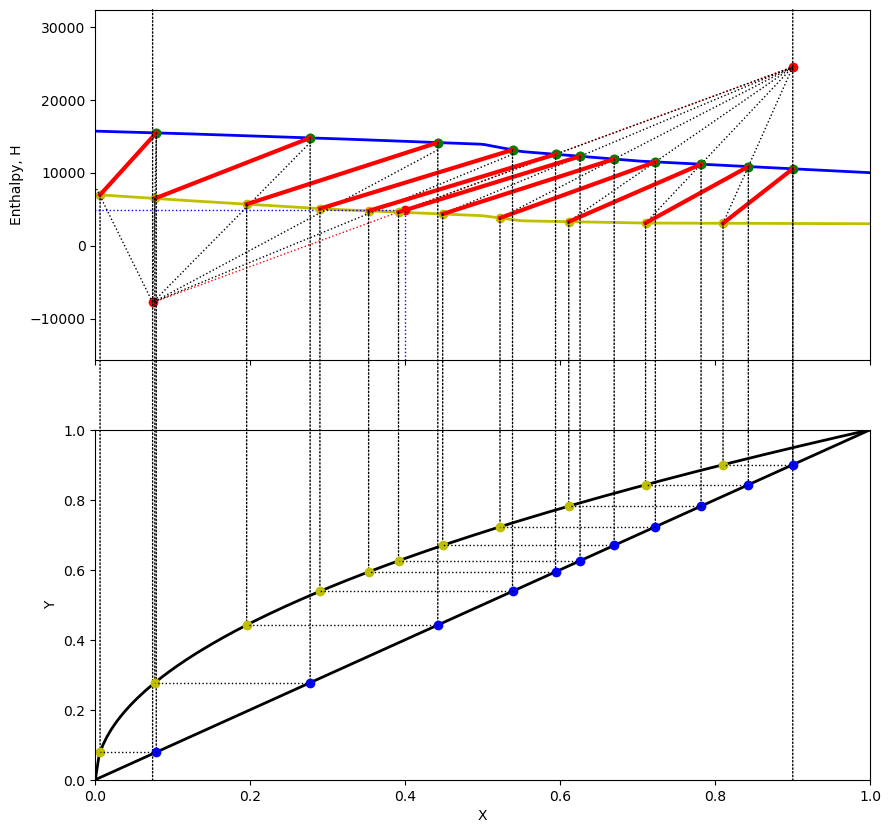

In [5]:
# Enthalpy Diagram (x,y)

# x values
x_values = np.array([0, 0.1, 0.3, 0.5, 0.55, 0.7, 1.0])  

# y values
vapor_enthalpy_values = np.array([15700, 15400, 14700, 13900, 12900, 11600, 10000])
liquid_enthalpy_values = np.array([7000, 6300, 5000, 4100, 3400, 3100, 3000])

#________________________________________________________________________________________#

# Fungsi interpolasi untuk mendapatkan nilai entalpi pada nilai x tertentu
def Vapor_Enthalpy(x):
    return np.interp(x, x_values, vapor_enthalpy_values)

def Liquid_Enthalpy(x):
    return np.interp(x, x_values, liquid_enthalpy_values)

# Fungsi y(x) tetap sama
def y(x):
    return np.sqrt(x)

pc = PonchonSavarit(y, Vapor_Enthalpy, Liquid_Enthalpy)

#________________________________________________________________________________________#

#addData(xD, xW, zF, F, dHD=None, dHW=None):      
pc.addData(xD=0.9,xW=0.074,zF=0.4,F=100,dHD=24500,dHW=-7800)

# just two of [dHW, dHD, HF] must be filled and the third value will be computed automaticaly
# Must: 0 < xD, xW, zF <1 
# Must: xD + xW = 1.0

pc.ComputeN()